In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from fastai.vision.all import *
from tqdm import tqdm

import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import multiprocessing
import torch.nn as nn
from PIL import Image
import pandas as pd
import numpy as np
import torchvision
import torch
import csv
import PIL
import os

In [3]:
PATH = './'
TRAIN_RATIO = 0.8
TRAIN = '../input/ship-data/my_shipdetection/subset_images' # Change to the local folder store the data
TEST = '../input/ship-data/my_shipdetection/subset_images' # Change to the local folder store the data
SEGMENTATION = '../input/ship-data/my_shipdetection/dataset.csv' # Change to the local folder store the data
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted image


In [4]:
nw = 4   #number of workers for data loader
arch = resnet34 #specify target architecture

In [5]:
# Get a list of all the image filenames in the TRAIN directory
all_image_filenames = [f for f in os.listdir(TRAIN)]

# Calculate the index to split the filenames into training and testing sets
split_index = int(len(all_image_filenames) * TRAIN_RATIO)

# Split the filenames into training and testing sets
train_names = all_image_filenames[:split_index]
test_names = all_image_filenames[split_index:]

#5% of data in the validation set is sufficient for model evaluation
tr_n, val_n = train_test_split(train_names, test_size=0.05, random_state=42)

In [6]:
# Loop through each element in the exclude_list and remove them from tr_n, val_n, and test_names if they exist
for el in exclude_list:
    if(el in tr_n): tr_n.remove(el)
    if(el in val_n): val_n.remove(el)
    if(el in test_names): test_names.remove(el)

# Read a CSV file called SEGMENTATION and set the 'ImageId' column as the index for the DataFrame
segmentation_df = pd.read_csv(SEGMENTATION).set_index('ImageId')


In [7]:
def get_mask(img_id, df):
    """
    Get the mask for a given image ID.

    Parameters:
    img_id (str): The ID of the image for which to get the mask.
    df (pandas.DataFrame): The DataFrame containing the encoded pixels for the masks.

    Returns:
    numpy.ndarray: An array representing the mask for the given image ID.
    """

    # Define the shape of the mask
    shape = (768, 768)

    # Create an array of zeros with the shape of the mask
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    # Get the encoded pixels for the mask of the given image ID
    masks = df.loc[img_id]['EncodedPixels']

    # If there are no masks for the image, return the zero array
    if(type(masks) == float):
        return img.reshape(shape)

    # If there is only one mask, convert it to a list
    if(type(masks) == str):
        masks = [masks]

    # Loop through the masks and fill in the pixels of the mask
    for mask in masks:
        s = mask.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1

    # Reshape the mask array to the shape of the mask and transpose it
    return img.reshape(shape).T


In [8]:
class pdFilesDataset(GetAttr):
    """
    A class for creating a dataset of image and mask pairs from a list of image filenames.

    Attributes:
    segmentation_df (pandas.DataFrame): The DataFrame containing the encoded pixels for the masks.

    Methods:
    get_x(i): Get the image at the specified index.
    get_y(i): Get the mask for the image at the specified index.
    get_c(): Get the number of classes in the dataset.
    """

    def __init__(self, fnames, path, transform):
        """
        Initialize the pdFilesDataset object.

        Parameters:
        fnames (list): A list of filenames for the images in the dataset.
        path (str): The path to the directory containing the image files.
        transform (callable): A function that takes in an image and transforms it.
        """
        self.default = self
        self.segmentation_df = pd.read_csv(SEGMENTATION).set_index('ImageId')
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        """
        Get the image at the specified index.

        Parameters:
        i (int): The index of the image to get.

        Returns:
        PIL.Image: The image at the specified index.
        """
        img = PIL.Image.open(os.path.join(self.path, self.fnames[i]))
        if self.sz == 768: return img 
        else: return img.resize((self.sz, self.sz), resample=PIL.Image.BILINEAR)
    
    def get_y(self, i):
        """
        Get the mask for the image at the specified index.

        Parameters:
        i (int): The index of the image to get the mask for.

        Returns:
        int: 1 if the image contains a ship, 0 otherwise.
        """
        if(self.path == TEST): return 0
        masks = self.segmentation_df.loc[self.fnames[i]]['EncodedPixels']
        if(type(masks) == float): return 0 #NAN - no ship 
        else: return 1
    
    def get_c(self):
        """
        Get the number of classes in the dataset.

        Returns:
        int: The number of classes in the dataset.
        """
        return 2 #number of classes


In [9]:
def label_func(fname):
    """
    Get the mask for a given image filename.

    Parameters:
    fname (str): The filename of the image for which to get the mask.

    Returns:
    PIL.Image: An Image object representing the mask for the given image filename.
    """
    return PIL.Image.fromarray(get_mask(os.path.basename(fname), segmentation_df))

def get_data(sz, bs):
    """
    Get the dataloaders for the dataset.

    Parameters:
    sz (int): The size to resize the images to.
    bs (int): The batch size to use.

    Returns:
    fastai.data.load.DataLoaders: The dataloaders for the dataset.
    """
    # Define the data augmentation transforms
    aug_tfms = setup_aug_tfms([Rotate(max_deg=20, p=1.),
                               Dihedral(p=1.),
                               Brightness(max_lighting=0.1, p=1.)])

    # Define the data block
    data_block = DataBlock(blocks=(ImageBlock, MaskBlock(codes=np.arange(2))),
                           get_items=lambda items: L(
                               [Path(TRAIN)/x for x in items]),
                           splitter=FuncSplitter(lambda o: o.name in val_n),
                           get_y=label_func,
                           item_tfms=Resize(sz),
                           batch_tfms=aug_tfms)

    # Return the dataloaders for the dataset
    return data_block.dataloaders(train_names, path=TRAIN, bs=bs, num_workers=nw)


In [10]:
class DecoderBlock(nn.Module):
    """
    A class representing a decoder block in a U-Net architecture.

    Attributes:
    block (nn.Sequential): The sequential block of layers in the decoder block.

    Methods:
    forward(x): Forward pass through the decoder block.
    """

    def __init__(self, in_channels, middle_channels, out_channels):
        """
        Initialize the DecoderBlock object.

        Parameters:
        in_channels (int): The number of channels in the input tensor.
        middle_channels (int): The number of channels in the middle tensor.
        out_channels (int): The number of channels in the output tensor.
        """
        super(DecoderBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, middle_channels,
                      kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(middle_channels, out_channels,
                               kernel_size=2, stride=2)
        )

    def forward(self, x):
        """
        Forward pass through the decoder block.

        Parameters:
        x (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The output tensor.
        """
        return self.block(x)


class UNetResNet34(nn.Module):
    """
    A class representing a U-Net model based on ResNet-34.

    Attributes:
    encoder (torchvision.models.resnet.ResNet): The ResNet-34 encoder.
    base_channels (int): The number of channels in the base layer.
    layer0 (nn.Sequential): The first layer of the encoder.
    layer1 (nn.Sequential): The second layer of the encoder.
    layer2 (nn.Module): The third layer of the encoder.
    layer3 (nn.Module): The fourth layer of the encoder.
    layer4 (nn.Module): The fifth layer of the encoder.
    decoder4 (DecoderBlock): The fourth decoder block.
    decoder3 (DecoderBlock): The third decoder block.
    decoder2 (DecoderBlock): The second decoder block.
    decoder1 (DecoderBlock): The first decoder block.
    final (nn.Conv2d): The final convolutional layer.

    Methods:
    forward(x): Forward pass through the model.
    """

    def __init__(self, num_classes):
        """
        Initialize the UNetResNet34 object.

        Parameters:
        num_classes (int): The number of classes in the output tensor.
        """
        super(UNetResNet34, self).__init__()
        self.encoder = torchvision.models.resnet34(pretrained=True)
        self.base_channels = 64

        self.encoder_layers = list(self.encoder.children())

        self.layer0 = nn.Sequential(*self.encoder_layers[:3])
        self.layer1 = nn.Sequential(*self.encoder_layers[3:5])
        self.layer2 = self.encoder_layers[5]
        self.layer3 = self.encoder_layers[6]
        self.layer4 = self.encoder_layers[7]

        self.decoder4 = DecoderBlock(512, 256, self.base_channels)
        self.decoder3 = DecoderBlock(
            256 + self.base_channels, 256, self.base_channels)
        self.decoder2 = DecoderBlock(
            128 + self.base_channels, 128, self.base_channels)
        self.decoder1 = DecoderBlock(
            64 + self.base_channels, 64, self.base_channels)

        self.final = nn.Conv2d(self.base_channels, num_classes, kernel_size=1)

    def forward(self, x):
        """
        Forward pass through the model.

        Parameters:
        x (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The output tensor.
        """
        x0 = self.layer0(x)
        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        dec4 = self.decoder4(x4)
        dec3 = self.decoder3(torch.cat([x3, dec4], 1))
        dec2 = self.decoder2(torch.cat([x2, dec3], 1))
        dec1 = self.decoder1(torch.cat([x1, dec2], 1))

        output = self.final(dec1)
        output = F.interpolate(output, size=(
            x.size(2), x.size(3)), mode='bilinear', align_corners=True)

        return output


# Instantiate the model
num_classes = 2
arch = UNetResNet34(num_classes)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [11]:
sz = 768  # image size
bs = 6  # batch size

dls = get_data(sz, bs)

In [12]:
def IoU(pred, target):
    """
    Computes the Intersection over Union (IoU) metric between the predicted and target segmentation maps.

    Parameters:
    pred (torch.Tensor): The predicted segmentation map.
    target (torch.Tensor): The target segmentation map.

    Returns:
    torch.Tensor: The Intersection over Union (IoU) score.
    """
    pred = pred.argmax(dim=1)  # Get the predicted segmentation map
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    return intersection / ((pred + target).sum() - intersection + 1.0)


In [12]:
# Set the number of steps to accumulate gradients
from fastai.metrics import foreground_acc
accumulation_steps = 2

learn = Learner(dls, arch, loss_func=nn.CrossEntropyLoss(),  metrics=[Dice(), IoU], cbs = GradientAccumulation(accumulation_steps))
learn.path = learn.model_dir = Path('/workingmodels')
# learn = learn.to_fp16() # If CUDA run out of memory

SuggestedLRs(valley=9.120108734350652e-05)

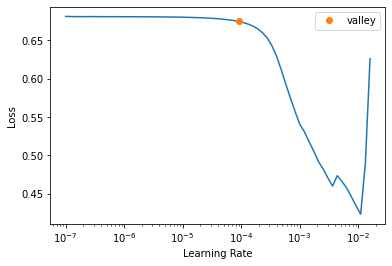

In [13]:
learn.lr_find()

In [14]:
learn.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,dice,IoU,time
0,0.003947,0.005026,0.622095,0.386485,25:28
1,0.003578,0.003092,0.778811,0.537013,25:15
2,0.004037,0.004968,0.461838,0.242527,25:21
3,0.004290,0.004809,0.729327,0.504821,25:19
4,0.003107,0.002811,0.816887,0.587648,25:21
5,0.002172,0.002048,0.850706,0.639523,25:16
6,0.002053,0.002328,0.795400,0.632892,25:15
7,0.001892,0.002401,0.824177,0.681062,25:25
8,0.001591,0.002426,0.835508,0.697063,25:28
9,0.002018,0.001614,0.881846,0.700247,25:20


train_loss: [0.003946727607399225, 0.0035782591439783573, 0.004036943428218365, 0.004290183540433645, 0.003106950782239437, 0.0021716400515288115, 0.002053343690931797, 0.0018922807648777962, 0.0015911906957626343, 0.0020175727549940348]
valid_loss: [0.005026340950280428, 0.0030919502023607492, 0.004968097433447838, 0.004808957688510418, 0.002811175538226962, 0.002048102905973792, 0.0023277190048247576, 0.0024010760243982077, 0.00242570205591619, 0.0016144540859386325]
dice: [0.6220953505185379, 0.7788109094560186, 0.46183819477792115, 0.7293267684216946, 0.8168872965688869, 0.8507062677054733, 0.7954003037103073, 0.8241767465109597, 0.8355075981778295, 0.8818455416520534]
IoU: [0.3864845335483551, 0.5370128750801086, 0.24252736568450928, 0.5048205256462097, 0.5876476168632507, 0.6395225524902344, 0.6328919529914856, 0.6810623407363892, 0.6970633864402771, 0.7002469897270203]


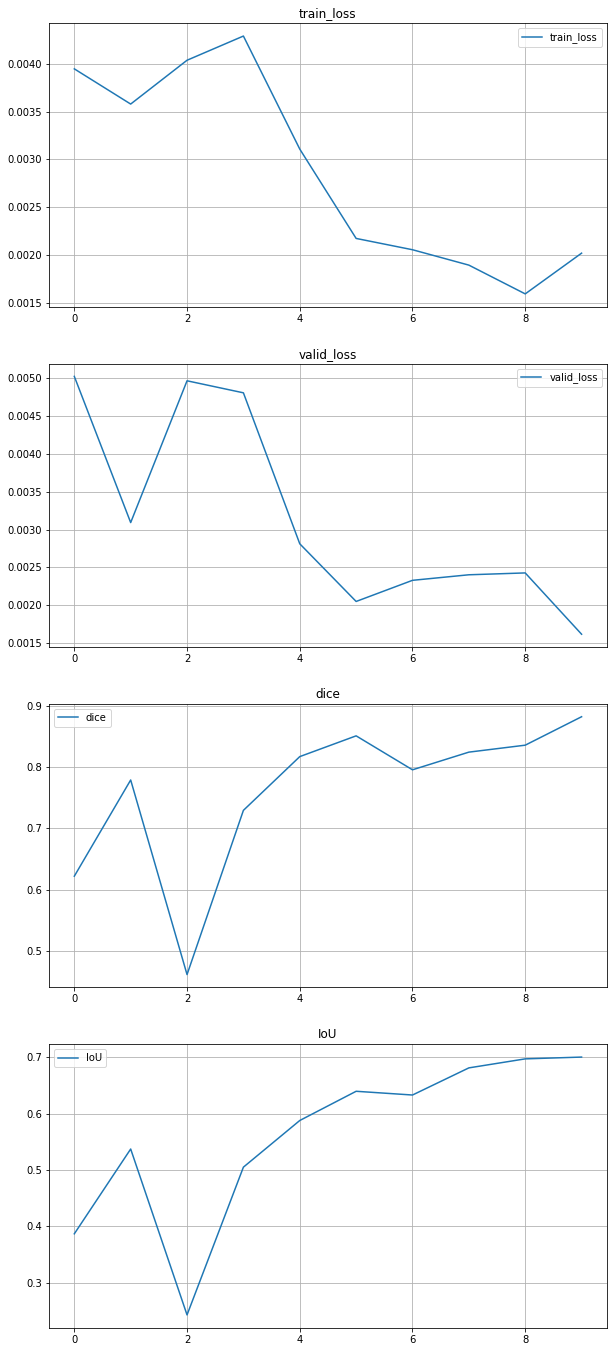

In [15]:
def plot_metrics(learner):
    """
    Plots the training and validation metrics of a fastai `Learner` object.

    Parameters:
    learner (fastai.learner.Learner): The `Learner` object.

    Returns:
    None.
    """
    metrics = learner.recorder.metric_names[1:-1]  # Exclude the first (epoch) and the last (time) metric names
    values = learner.recorder.values
    n_metrics = len(metrics)

    fig, axes = plt.subplots(n_metrics, 1, figsize=(10, n_metrics * 6))  # Increase the width and height of the plot

    for i, (metric, ax) in enumerate(zip(metrics, axes)):
        metric_values = [x[i] for x in values]
        print(f"{metric}: {metric_values}")
        ax.plot(metric_values, label=metric)
        ax.set_title(metric)
        ax.legend()
        ax.grid(True)

    plt.savefig('/img/freeze_' + str(sz) + '_105.png')
    plt.show()
    

plot_metrics(learn)

In [16]:
learn.unfreeze()

In [17]:
learn.fit_one_cycle(5, lr_max=slice(1e-4, 2e-3))

epoch,train_loss,valid_loss,dice,IoU,time
0,0.003061,0.003902,0.774301,0.593414,25:15
1,0.002877,0.003715,0.730524,0.536653,25:15
2,0.002330,0.002186,0.844817,0.637479,25:11
3,0.001801,0.001700,0.874893,0.681457,25:05
4,0.001476,0.001857,0.834478,0.695935,25:05


train_loss: [0.003061301540583372, 0.0028771201614290476, 0.002330481307581067, 0.00180061103310436, 0.0014759517507627606]
valid_loss: [0.003901667892932892, 0.0037154252640902996, 0.0021864338777959347, 0.0017003463581204414, 0.0018572770059108734]
dice: [0.7743013490979662, 0.7305236194788342, 0.84481702233492, 0.8748931783025536, 0.8344784077702002]
IoU: [0.5934135317802429, 0.5366530418395996, 0.637478768825531, 0.6814573407173157, 0.6959352493286133]


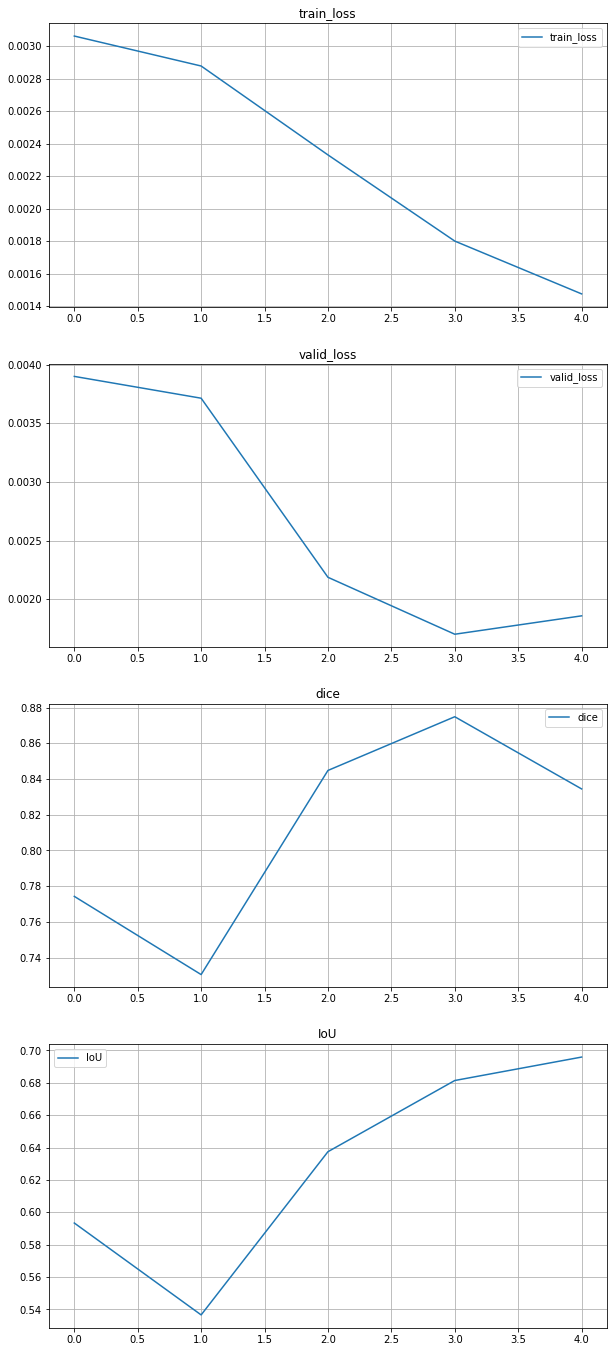

In [18]:
def plot_metrics(learner):
    """
    Plots the training and validation metrics of a fastai `Learner` object.

    Parameters:
    learner (fastai.learner.Learner): The `Learner` object.

    Returns:
    None.
    """
    metrics = learner.recorder.metric_names[1:-1]  # Exclude the first (epoch) and the last (time) metric names
    values = learner.recorder.values
    n_metrics = len(metrics)

    fig, axes = plt.subplots(n_metrics, 1, figsize=(10, n_metrics * 6))  # Increase the width and height of the plot

    for i, (metric, ax) in enumerate(zip(metrics, axes)):
        metric_values = [x[i] for x in values]
        print(f"{metric}: {metric_values}")
        ax.plot(metric_values, label=metric)
        ax.set_title(metric)
        ax.legend()
        ax.grid(True)

    plt.savefig('/img/unfreeze_' + str(sz) + '_105.png')
    plt.show()
    

plot_metrics(learn)

In [19]:
learn.export('Unet34_lable_' + str(sz) + str(bs) + '_v1.1')

In [20]:
# 1. Load the image from the test dataset
img_name = test_names[np.random.randint(len(test_names))]
test_image_path = os.path.join(TEST, img_name)
test_image = PIL.Image.open(test_image_path)

In [21]:
# 2. preprocessed image
preprocessed_image = test_image.resize((sz, sz), resample=Image.BILINEAR)
transform = transforms.ToTensor()  # Convert to tensor
preprocessed_image = transform(preprocessed_image)
preprocessed_image = Normalize.from_stats(*imagenet_stats)(preprocessed_image)
preprocessed_image = torch.unsqueeze(preprocessed_image, 0).to(dls.device)

In [22]:
# 3. Pass the preprocessed image through the trained model
with torch.no_grad():
    output = learn.model(preprocessed_image)

In [23]:
# 4. Apply the softmax function and take the argmax
output_probabilities = F.softmax(output, dim=1)
segmentation_map = torch.argmax(output_probabilities, dim=1)

In [ ]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

img_masks = [mask for mask in segmentation_df.loc[img_name].tolist() if isinstance(mask, str)]

# Take the individual ship masks and create a single mask array for all ships
all_masks = np.zeros((768, 768))
for mask in img_masks:
    all_masks += rle_decode(mask)

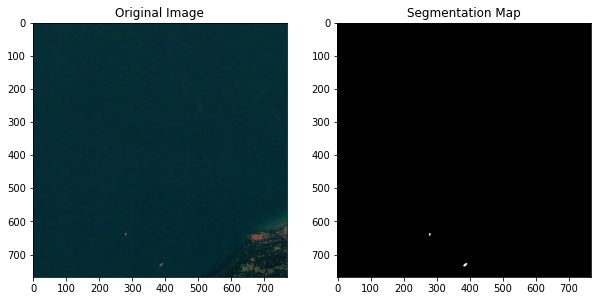

In [24]:
# 5. Plot the original image and the segmentation map
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
ax1.imshow(test_image)
ax1.set_title("Original Image")
ax2.imshow(segmentation_map.squeeze().cpu().numpy(), cmap='gray')
ax2.set_title("Predict Segmentation Map")
ax3.imshow(all_masks)
ax3.set_title("True Segmentation Map")
plt.savefig('/img/img7682.png')
plt.show()

In [15]:
def iou(pred, target, eps=1e-7):
    """
    Computes the Intersection over Union (IoU) metric between the predicted and target segmentation masks.

    Parameters:
    pred (torch.Tensor): The predicted segmentation mask.
    target (torch.Tensor): The target segmentation mask.
    eps (float): A small value added to the denominator to avoid division by zero.

    Returns:
    float: The Intersection over Union (IoU) score.
    """
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + eps) / (union + eps)


def f2_score(y_true, y_pred, beta=2):
    """
    Computes the F2 score between the true and predicted binary labels.

    Parameters:
    y_true (numpy.ndarray): The true binary labels.
    y_pred (numpy.ndarray): The predicted binary labels.
    beta (float): The beta parameter of the Fbeta score.

    Returns:
    float: The F2 score.
    """
    return fbeta_score(y_true, y_pred, beta=beta, average='binary')


iou_thresholds = np.arange(0.5, 1.0, 0.05)

def process_image(test_image_name):
    """
    Processes a test image and returns the resized ground truth mask and F2 scores.

    Parameters:
    test_image_name (str): The name of the test image file.

    Returns:
    tuple: A tuple containing the resized ground truth mask as a numpy array, and a list of F2 scores.
    """
    test_image = PIL.Image.open(os.path.join(TEST, test_image_name))
    ground_truth_mask_origin = get_mask(test_image_name, segmentation_df)
    ground_truth_mask = ground_truth_mask_origin.copy()

    ground_truth_mask = PIL.Image.fromarray(ground_truth_mask)
    ground_truth_mask_resized = ground_truth_mask.resize((sz, sz), resample=PIL.Image.BILINEAR)
    ground_truth_mask_resized = np.array(ground_truth_mask_resized)

    preprocessed_image = test_image.resize((sz, sz))
    transform = transforms.ToTensor()
    preprocessed_image = transform(preprocessed_image)
    preprocessed_image = torch.unsqueeze(preprocessed_image, 0).to(dls.device)

    with torch.no_grad():
        output = learn.model(preprocessed_image)

    output_probabilities = F.softmax(output, dim=1)
    segmentation_map = torch.argmax(output_probabilities, dim=1).squeeze().cpu().numpy()

    iou_score = iou(segmentation_map, np.array(ground_truth_mask_resized))

    f2_scores_iou = []

    for t in iou_thresholds:
        y_pred = (output_probabilities.squeeze().cpu().numpy()[1] > t).astype(int)
        if np.sum(ground_truth_mask_resized) == 0 and np.sum(y_pred) == 0:
            f2 = 1
        else:
            f2 = f2_score(ground_truth_mask_resized.flatten(), y_pred.flatten())
        f2_scores_iou.append(f2)
    
    return ground_truth_mask_resized, f2_scores_iou


In [16]:
num_threads = multiprocessing.cpu_count()
print(f'number of thread is {num_threads}')

# Create a progress bar using tqdm
with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    results = list(tqdm(executor.map(process_image, test_names), total=len(test_names), desc='Processing images'))

ground_truth_masks, f2_scores_iou = zip(*results)

number of thread is 96


Processing images: 100%|██████████| 17023/17023 [1:02:50<00:00,  4.51it/s]


In [17]:
# Calculate the mean F2 score for each IoU threshold
mean_f2_scores = np.mean(f2_scores_iou, axis=0)
print(mean_f2_scores)

[0.81709877 0.80894808 0.79988544 0.78958897 0.77710992 0.7620765
 0.74564558 0.72542503 0.70006555 0.66504804]


In [18]:
for t, f2 in zip(iou_thresholds, mean_f2_scores):
    print(f"IoU threshold: {t:.2f}, Mean F2 score: {f2:.4f}")

IoU threshold: 0.50, Mean F2 score: 0.8171
IoU threshold: 0.55, Mean F2 score: 0.8089
IoU threshold: 0.60, Mean F2 score: 0.7999
IoU threshold: 0.65, Mean F2 score: 0.7896
IoU threshold: 0.70, Mean F2 score: 0.7771
IoU threshold: 0.75, Mean F2 score: 0.7621
IoU threshold: 0.80, Mean F2 score: 0.7456
IoU threshold: 0.85, Mean F2 score: 0.7254
IoU threshold: 0.90, Mean F2 score: 0.7001
IoU threshold: 0.95, Mean F2 score: 0.6650


In [ ]:
num_threads = multiprocessing.cpu_count()
print(f'number of thread is {num_threads}')

TEST_set = '../input/airbus-ship-detection/test_v2'
test_names_set = [f for f in os.listdir(TEST_set)]

def rle_encode(mask):
    """
    Encodes a binary mask in Run-Length Encoding (RLE) format.

    Parameters:
    mask (numpy.ndarray): The binary mask to be encoded.

    Returns:
    str: A string representing the encoded mask in RLE format.
    """
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def process_image(test_image_name):
    """
    Processes a test image to produce a RLE-encoded binary mask.

    Parameters:
    test_image_name (str): The name of the test image file.

    Returns:
    str: A string representing the RLE-encoded binary mask.
    """
    test_image = PIL.Image.open(os.path.join(TEST_set, test_image_name))

    preprocessed_image = test_image.resize((sz, sz))
    transform = transforms.ToTensor()
    preprocessed_image = transform(preprocessed_image)
    preprocessed_image = torch.unsqueeze(preprocessed_image, 0).to(dls.device)

    with torch.no_grad():
        output = learn.model(preprocessed_image)

    output_probabilities = F.softmax(output, dim=1)

    # Create a binary mask using a threshold (e.g., 0.5)
    binary_mask = (output_probabilities.squeeze().cpu().numpy()[1] > 0.5).astype(np.uint8)

    # Encode the binary mask using RLE
    rle_encoded_mask = rle_encode(binary_mask)
    
    return rle_encoded_mask

# Create a progress bar using tqdm
with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    rle_encoded_masks = list(tqdm(executor.map(process_image, test_names_set), total=len(test_names_set), desc='Processing images'))

# Write the results to a CSV file
with open('test_masks_786_10.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ImageId', 'EncodedPixels'])
    for test_image_name, rle_encoded_mask in zip(test_names_set, rle_encoded_masks):
        writer.writerow([test_image_name, rle_encoded_mask])



number of thread is 96


Processing images:  97%|█████████▋| 15185/15606 [24:23<00:33, 12.55it/s] 

In [ ]:
print('Finished')